In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import rfpimp
from matplotlib import pyplot as plt
from math import sqrt
import scipy.stats as stats
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LassoCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# QCEW data

# 2017
df17 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2017.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2018
df18 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2018.xlsx',
                     sheet_name='US_St_Cn_MSA')
# 2019
df19 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2019.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2020
df20 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2020.xlsx', 
                     sheet_name='US_St_Cn_MSA')
# 2021
df21 = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/2021.xlsx', 
                     sheet_name='US_St_Cn_MSA')

In [3]:
# JOLTS data
j = pd.read_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/pre-processed/jolts_2017_2021.xlsx', 
                     sheet_name='jolts')

In [4]:
# Union the QCEW annual files
df = pd.concat([df17,df18,df19,df20,df21])

In [5]:
# Get info on the columns and datatypes
print(df.info())
print(j.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314467 entries, 0 to 63008
Data columns (total 20 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Area
Code                                      314467 non-null  object 
 1   St                                             280848 non-null  object 
 2   Cnty                                           280848 non-null  float64
 3   Own                                            314467 non-null  int64  
 4   NAICS                                          314467 non-null  int64  
 5   Year                                           314467 non-null  int64  
 6   Qtr                                            314467 non-null  object 
 7   Area Type                                      314467 non-null  object 
 8   St Name                                        280758 non-null  object 
 9   Area                                  

In [6]:
# Rename columns
df.rename(columns={'Year' : 'year',
                   'Area Type': 'area_type',
                   'St Name': 'state',
                   'Ownership': 'ownership',
                   'Industry': 'industry',
                   'Annual Average Establishment Count': 'num_est',
                   'Annual Average Employment': 'num_emp',
                   'Annual Total Wages': 'total_wage',
                   'Annual Average Weekly Wage': 'weekly_wage',
                   'Annual Average Pay': 'annual_wage',
                   'Employment Location Quotient Relative to U.S.': 'elq',
                   'Total Wage Location Quotient Relative to U.S.': 'wlq'},
          inplace=True)

In [7]:
# Creating subsets that are most expressive of the desired results
df2 = df.loc[(df["area_type"] == 'State') # Other levels do not express results well
                  & (df["ownership"] == 'Private') # Other levels do not contain any industry-level data
                  & (df["industry"] != '1029 Unclassified') # Not all states contain this level, so it may inflate results
                  & (df["industry"] != '10 Total, all industries') # Removing to avoid redundancy
                  & (df["industry"] != '101 Goods-producing') # This is a parent category. Removing to avoid redundancy.
                  & (df["industry"] != '102 Service-providing') # This is a parent category. Removing to avoid redundancy.
                  & (df["Annual Average Status Code"] != 'N')] # Nothing reported for this level.


In [8]:
# Removing code from beginning of each industry level
df2['industry'] = [item[5:] for item in df2['industry']]

/var/folders/9y/lj7qm_g14lb32t9p53gc__j80000gp/T/ipykernel_62321/2678224554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['industry'] = [item[5:] for item in df2['industry']]


In [9]:
# Select columns you want to keep in the final dataset.
df2 = df2.iloc[:,[5,8,11,13,14,15,16,17,18,19]]

In [10]:
# Get information on latest dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538 entries, 24 to 55842
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         2538 non-null   int64  
 1   state        2538 non-null   object 
 2   industry     2538 non-null   object 
 3   num_est      2538 non-null   int64  
 4   num_emp      2538 non-null   int64  
 5   total_wage   2538 non-null   int64  
 6   weekly_wage  2538 non-null   int64  
 7   annual_wage  2538 non-null   int64  
 8   elq          2538 non-null   float64
 9   wlq          2538 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 218.1+ KB


In [11]:
# Merge the clean QCEW data and JOLTS data. 
# Take a look at the first 10 records and the table structure

df_final = pd.merge(df2,j)
print(df_final.head(10))
print(df_final.info())

   year    state                              industry  num_est  num_emp  \
0  2017  Alabama          Natural resources and mining     1815    17999   
1  2017  Alabama                          Construction     9645    85262   
2  2017  Alabama                         Manufacturing     5447   263487   
3  2017  Alabama  Trade, transportation, and utilities    32410   375653   
4  2017  Alabama                           Information     1969    20807   
5  2017  Alabama                  Financial activities    13089    94756   
6  2017  Alabama    Professional and business services    21426   239356   
7  2017  Alabama         Education and health services    12429   229821   
8  2017  Alabama               Leisure and hospitality    10741   202336   
9  2017  Alabama                        Other services     9603    45296   

    total_wage  weekly_wage  annual_wage   elq   wlq  quits  job_openings  
0    949424301         1014        52748  0.71  0.79    2.4           3.8  
1   4453218

In [ ]:
# Write to excel
df_final.to_excel('/Users/omar.hassan/Documents/DAEN/DAEN 698/QCEW Data/Final Data/df_final.xlsx')

# Multicollinearity

<AxesSubplot:>

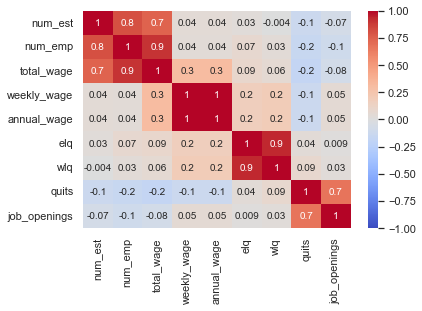

In [12]:
# Correlation plot

df_corr = df_final.iloc[:,3:]
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(df_corr.corr(), annot = True, fmt='.1g',vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

# Feature Importance

In [13]:
# Assigning features

features = df_final.iloc[:,[3,4,5,6,7,8,9,10]].columns # Excluding Job Openings
#features = df_corr.columns                            # Including Job Openings

features

Index(['num_est', 'num_emp', 'total_wage', 'weekly_wage', 'annual_wage', 'elq',
       'wlq', 'quits'],
      dtype='object')

In [14]:
# Splitting the data

df_train, df_test = train_test_split(df_final, test_size=0.20)
df_train = df_train[features]
df_test = df_test[features]

X_train, y_train = df_train.drop('quits',axis=1), df_train['quits']
X_test, y_test = df_test.drop('quits',axis=1), df_test['quits']

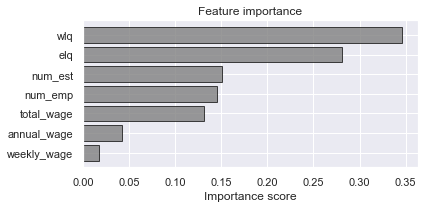

In [15]:
# Fit Random Forest model without tuning

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# Feature Importance

imp = rfpimp.importances(rf, X_test, y_test)

# Plot

fig, ax = plt.subplots(figsize=(6, 3))

ax.barh(imp.index, imp['Importance'], height=0.8, facecolor='grey', alpha=0.8, edgecolor='k')
ax.set_xlabel('Importance score')
ax.set_title('Feature importance')
plt.gca().invert_yaxis()

fig.tight_layout()

# Linear Regression

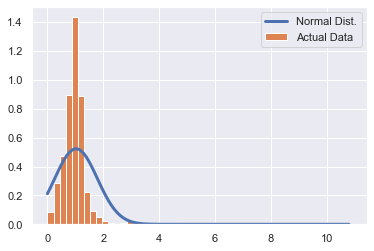

In [16]:
# Check distribution of most important feature

%matplotlib inline

# Plot a histogram of the observed data
# Included is expected distribution, if the data is normally distributed, with the same mean and std of the data.

d1 = df_final['wlq']
xs = np.arange(d1.min(), d1.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(d1), np.std(d1))
plt.plot(xs, fit, label='Normal Dist.', lw=3)
plt.hist(d1, 50, density=True, label='Actual Data');
plt.legend();

In [17]:
# Test train split

X, y = df_final['wlq'], df_final['quits']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [18]:
# Fit the model

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

lr = LinearRegression()
model = lr.fit(X_train, y_train)

In [19]:
# Model Evaluation

pred_train_lr= lr.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_lr)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_lr),2))

print('') # Blank Space

pred_test_lr= lr.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_lr)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_lr),2))

Train Data RMSE:  0.49
Train Data R2:  0.0

Test Data RMSE:  0.49
Test Data R2:  0.01


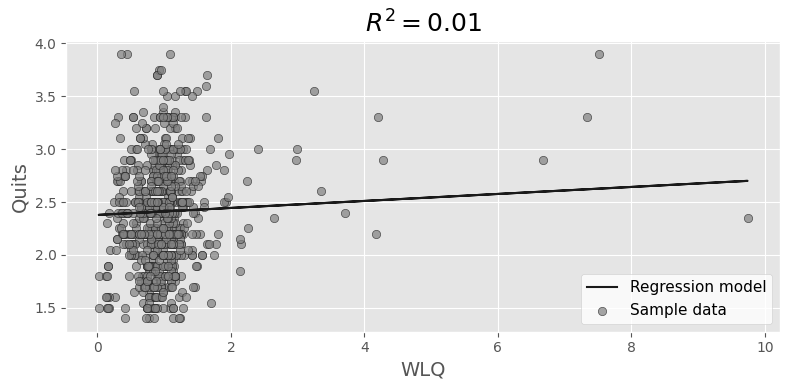

In [20]:
# Plot

plt.style.use('default')
plt.style.use('ggplot')

r2 = model.score(X_test, y_test)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X_test, pred_test_lr, color='k', label='Regression model')
ax.scatter(X_test, y_test, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('Quits', fontsize=14)
ax.set_xlabel('WLQ', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()

# Multiple Linear Regression

In [21]:
# Test train split

X, y = df_final.iloc[:,[3,4,5,6,7,8,9]], df_final.iloc[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
# Standardization - Part of Data preprocessing

list_numerical = X.columns

scaler = MinMaxScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])

X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [23]:
# Fit the model

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [24]:
# Model Evaluation

pred_train_lr= lr.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_lr)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_lr),2))

print('') # Blank Space

pred_test_lr= lr.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_lr)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_lr),2))

Train Data RMSE:  1.04
Train Data R2:  0.02

Test Data RMSE:  1.04
Test Data R2:  0.01


Text(0, 0.5, 'Predicted')

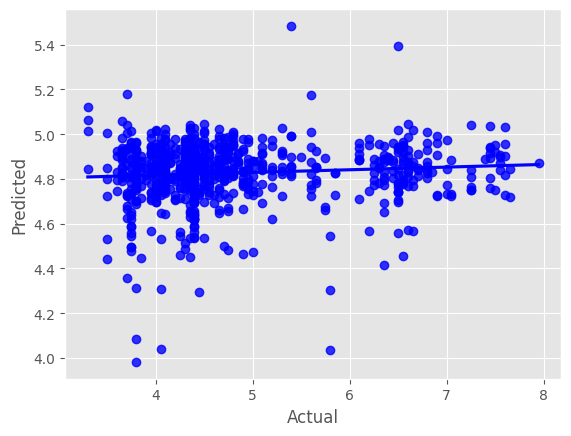

In [25]:
sns.regplot(x=y_test,y=pred_test_lr,ci=None,color ='blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Ridge Regression

In [26]:
# Ridge with 5 fold cross-validation

model = RidgeCV(cv=5)
model.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [27]:
# Use the optimal alphas
rr = Ridge(alpha=model.alpha_)

# Fit the model
rr.fit(X_train, y_train)

# Show coefficients
print(list(zip(rr.coef_, X)))

[(0.5023666835201663, 'num_est'), (-0.75810717704015, 'num_emp'), (-0.44209674191737763, 'total_wage'), (0.2573511853917747, 'weekly_wage'), (0.26009200862313847, 'annual_wage'), (-1.094606319511849, 'elq'), (0.7784759236400405, 'wlq')]


In [28]:
# Model Evaluation

pred_train_rr= rr.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_rr)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_rr),2))

print('') # Blank Space

pred_test_rr= rr.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_rr)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_rr),2))

Train Data RMSE:  1.04
Train Data R2:  0.02

Test Data RMSE:  1.04
Test Data R2:  0.01


# Lasso Regression

In [29]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [30]:
# Use the optimal alpha
lasso = Lasso(alpha=model.alpha_)

# Fit the model
lasso.fit(X_train, y_train)

# Show coefficients
print(list(zip(lasso.coef_, X)))

[(0.0, 'num_est'), (-0.8048328817485965, 'num_emp'), (-0.0, 'total_wage'), (0.18620279448550023, 'weekly_wage'), (0.12877814438337257, 'annual_wage'), (-0.18467569098787692, 'elq'), (0.0, 'wlq')]


In [31]:
# Model Evaluation

pred_train_lasso= lasso.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_lasso)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_lasso),2))

print('') # Blank Space

pred_test_lasso= lasso.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ', round(np.sqrt(mean_squared_error(y_test,pred_test_lasso)),2)) 
print('Test Data R2: ', round(r2_score(y_test, pred_test_lasso),2))

Train Data RMSE:  1.04
Train Data R2:  0.01

Test Data RMSE:  1.03
Test Data R2:  0.01


# Random Forest

In [32]:
# Test train split

X, y = df_final.iloc[:,[3,4,5,6,7,8,9]], df_final.iloc[:,11]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [33]:
# Fit Random Forest model with minimal tuning
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

In [34]:
# Model Evaluation

pred_train_rf= rf.predict(X_train) # Train Data Prediction
print('Train Data RMSE: ', round(np.sqrt(mean_squared_error(y_train,pred_train_rf)),2))
print('Train Data R2: ', round(r2_score(y_train, pred_train_rf),2))

print('') # Blank Space

pred_test_rf= rf.predict(X_test) # Test Data Prediction
print('Test Data RMSE: ',round(np.sqrt(mean_squared_error(y_test,pred_test_rf)),2))
print('Test Data R2: ',round(r2_score(y_test, pred_test_rf),2))

Train Data RMSE:  0.36
Train Data R2:  0.88

Test Data RMSE:  1.0
Test Data R2:  0.08


In [35]:
# Feature Importance 

def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

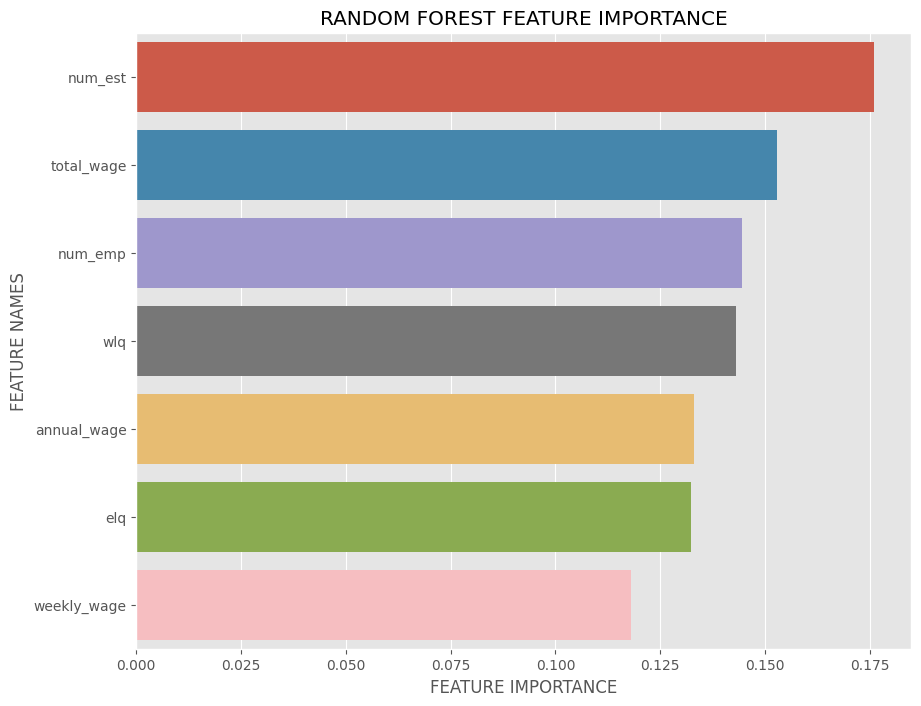

In [36]:
# Feature Importance Plot

plot_feature_importance(rf.feature_importances_,X_train.columns,'RANDOM FOREST ')